## Example Use of NIRCam Data Simulator to generate Imaging Exposures

The simulator is broken up into three basic stages:

1. Creation of a "seed image".
   This is generally a noiseless countrate image that contains signal
   only from the astronomical sources to be simulated. Currently, the 
   nircam_simulator package contains code to produce a seed image starting
   from object catalogs.
   
2. Dark current prep.
   The simualted data will be created by adding the simulated sources
   in the seed image to a real NIRCam dark current exposure. This step
   converts the dark current exposure to the requested readout pattern
   and subarray size requested by the user.
   
3. Observation generator.
   This step converts the seed image into an exposure of the requested
   readout pattern and subarray size. It also adds cosmic rays and 
   Poisson noise, as well as other detector effects (IPC, crosstalk, etc).
   This exposure is then added to the dark current exposure from step 2.

In [1]:
# Set the NIRCAM_SIM_DATA environment variable if it is not
# set already. This is for users at STScI.
import os
os.environ['NIRCAM_SIM_DATA'] = '/ifs/jwst/wit/nircam/nircam_simulator_data'

In [2]:
# Import the three steps of the simulator. 
from nircam_simulator.scripts import catalog_seed_image
from nircam_simulator.scripts import dark_prep
from nircam_simulator.scripts import obs_generator
from nircam_simulator.scripts import imaging_simulator

In [26]:
# For examining outputs
from glob import glob
from scipy.stats import sigmaclip
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# yaml file that contains the parameters of the
# data to be simulated
# Example yaml file shown at the bottom of this
# notebook
yamlfile = 'imaging_test.yaml'

## First generate the "seed image" 
This is generally a 2D noiseless countrate image that contains only 
simulated astronomical sources

In [7]:
cat = catalog_seed_image.Catalog_seed()
cat.paramfile = yamlfile
seedimage, segmap, seedinfo = cat.make_seed()

'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/catalog_seed_image/catalog_seed_image/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/catalog_seed_image/catalog_seed_image/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/catalog_seed_image/catalog_seed_image/config/NIRCam_zeropoints.list for Reffiles:flux_cal input file
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424024002P000000000112o_B5_F250M_uncal_pointsources.list.
Number of point sources found within the requested aperture: 251
Galaxy list input positions assumed to be in units of RA and Dec.
Galaxy list input radii 

### Look at the seed image

In [50]:
def show(array,title,min=0,max=1000):
    plt.figure(figsize=(12,12))
    plt.imshow(array,clim=(min,max))
    plt.title(title)
    plt.colorbar().set_label('DN$^{-}$/s')

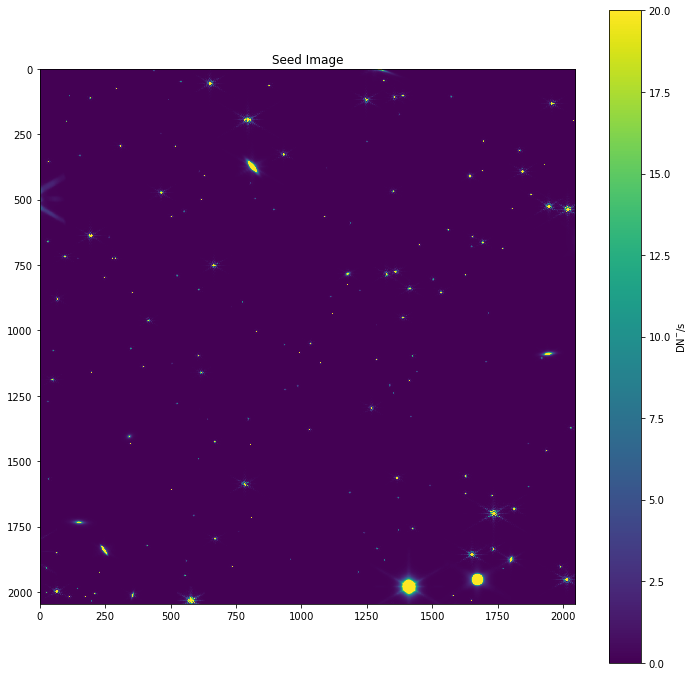

In [51]:
show(cat.seedimage,'Seed Image',max=20)

## Prepare the dark current exposure
This will serve as the base of the simulated data.
This step will linearize the dark current (if it 
is not already), and reorganize it into the 
requested readout pattern and number of groups.

In [22]:
d = dark_prep.DarkPrep()
d.paramfile = yamlfile
d.prepare()

'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/dark_prep/dark_prep/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/dark_prep/dark_prep/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/dark_prep/dark_prep/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/dark_prep/dark_prep/config/dq_init.cfg for newRamp:dq_configfile input file
'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/dark_prep/dark_prep/config/saturation.cfg for newRamp:sat_configfile input file
'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/dark_prep/dark_prep/config/superbias.cfg for newRamp:superbias_configfile input file
'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_

### Look at the dark current 
For this, we will look at an image of the final group
minus the first group

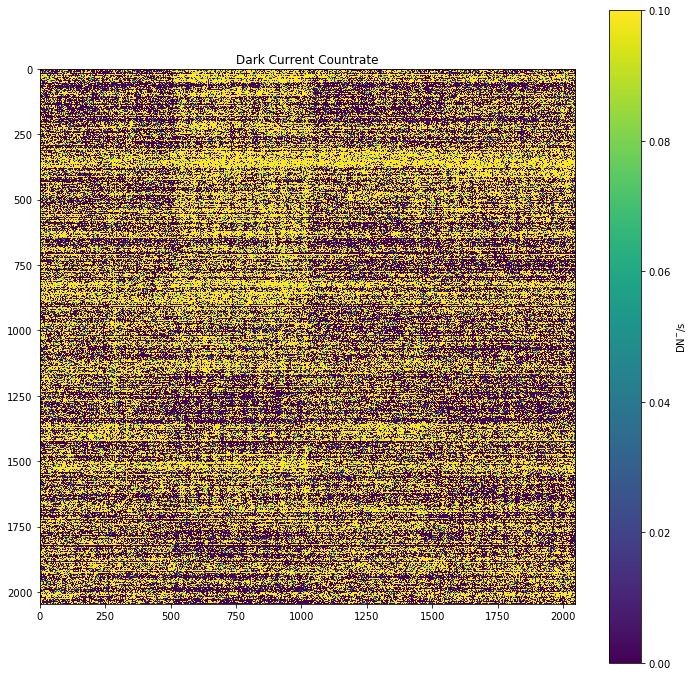

In [27]:
exptime = d.linDark.header['NGROUPS'] * cat.frametime
diff = (d.linDark.data[0,-1,:,:] - d.linDark.data[0,0,:,:]) / exptime
show(diff,'Dark Current Countrate',max=0.1)

## Create the final exposure
Turn the seed image into a exposure of the 
proper readout pattern, and combine it with the
dark current exposure. Cosmic rays and other detector
effects are added. 

The output can be either this linearized exposure, or
a 'raw' exposure where the linearized exposure is 
"unlinearized" and the superbias and 
reference pixel signals are added, or the user can 
request both outputs. This is controlled from
within the yaml parameter file.

In [79]:
obs = obs_generator.Observation()
obs.linDark = d.prepDark
obs.seed = cat.seedimage
obs.segmap = cat.seed_segmap
obs.seedheader = cat.seedinfo
obs.paramfile = yamlfile
obs.create()


Running observation generator....

We are paying attention to a bunch of inputs here
that are not acutally used.
'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/obs_generator/obs_generator/config/NIRCam_subarray_definitions.list for Reffiles:subarray_defs input file
'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/obs_generator/obs_generator/config/nircam_read_pattern_definitions.list for Reffiles:readpattdefs input file
'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/obs_generator/obs_generator/config/xtalk20150303g0.errorcut.txt for Reffiles:crosstalk input file
'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/obs_generator/obs_generator/config/nircam_filter_pupil_pairings.list for Reffiles:filtpupilcombo input file
'config' specified: Using /ifs/jwst/wit/nircam/hilbert/python_repos/obs_generator/obs_generator/config/NIRCam_zeropoints.list for Reffiles:flux_cal input file
Requested readout pattern RAPID is

WCS info for /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424024002P000000000112o_B5_F250M_linear.fits complete.


Final output integration saved to /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424024002P000000000112o_B5_F250M_linear.fits
Final linearized exposure saved to:
/ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424024002P000000000112o_B5_F250M_linear.fits


WCS info for /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424024002P000000000112o_B5_F250M_uncal.fits complete.


Final output integration saved to /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424024002P000000000112o_B5_F250M_uncal.fits
Final raw exposure saved to
/ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424024002P000000000112o_B5_F250M_uncal.fits


### Examine the final output image
Again, we will look at the last group minus the first group

In [65]:
linfile = '/ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424024002P000000000112o_B5_F250M_linear.fits'
with fits.open(linfile) as h:
    lindata = h[1].data
    header = h[0].header

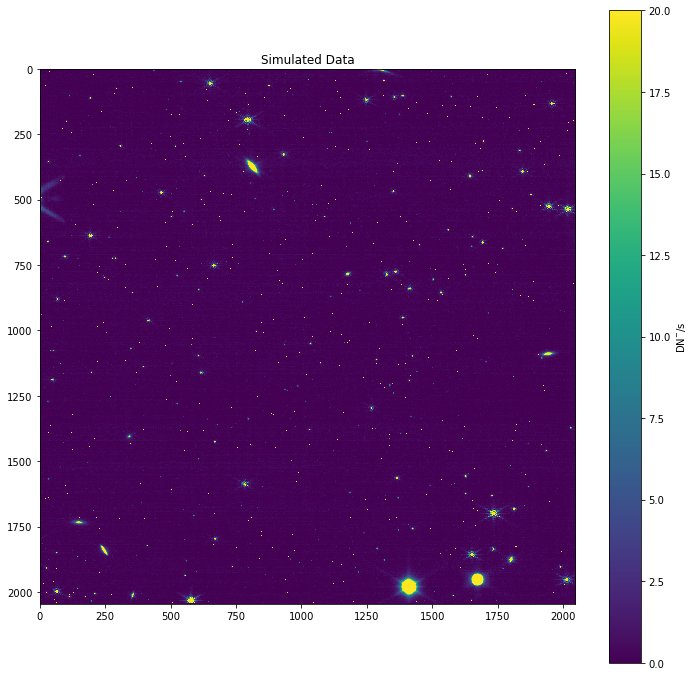

In [66]:
exptime = header['EFFINTTM']
diffdata = (lindata[0,-1,:,:] - lindata[0,0,:,:]) / exptime
show(diffdata,'Simulated Data',min=0,max=20)

/Users/hilbert/anaconda/envs/seed_dark_obsgen_test/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


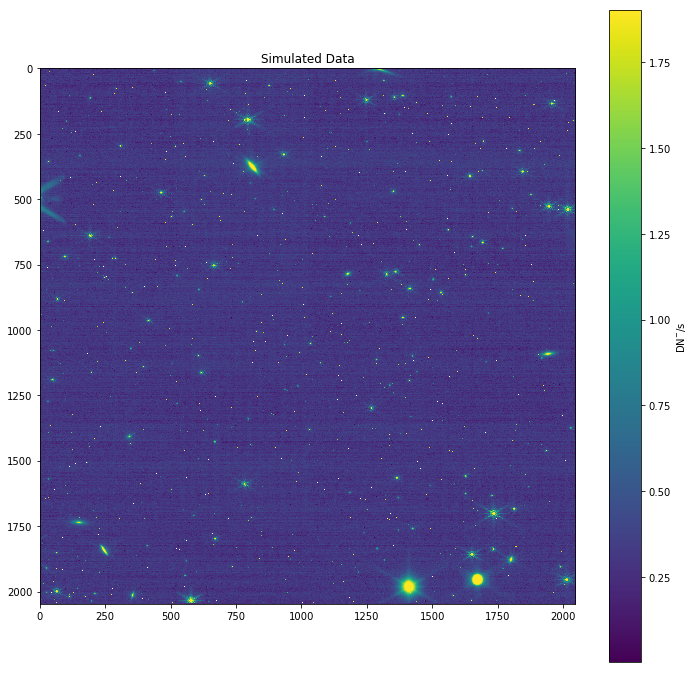

In [78]:
# Show on a log scale, to bring out the presence of the dark current
# Noise in the CDS image makes for a lot of pixels with values < 0,
# which makes this kind of an ugly image. Add an offset so that
# everything is positive and the noise is visible
offset = 2.
plt.figure(figsize=(12,12))
plt.imshow(np.log10(diffdata+offset),clim=(0.001,np.log10(80)))
plt.title('Simulated Data')
plt.colorbar().set_label('DN$^{-}$/s')

## For convenience, combine the three steps into a single function.

By having modular steps, the steps can be combined in various ways. For example, for wide field slitless simulations, the seed image can be fed into the disperser code, which returns a dispersed seed image. This seed image can then be run through the observation generator.

The function below will run all three steps for each exposure it is given.

In [33]:
def make_sim(paramfile):
    # Create seed image
    cat = catalog_seed_image.Catalog_seed()
    cat.paramfile = paramfile
    seedimage, segmap, seedinfo = cat.make_seed()
    
    # Prepare dark current exposure
    d = dark_prep.DarkPrep()
    d.paramfile = paramfile
    d.prepare()
    
    # Combine into final observation
    obs = obs_generator.Observation()
    obs.linDark = d.prepDark
    obs.seed = cat.seedimage
    obs.segmap = cat.seed_segmap
    obs.seedheader = cat.seedinfo
    obs.paramfile = paramfile
    obs.create()

However, if you have multiple exposures that will use the same dark current image (with the same readout pattern, subarray size, and number of groups), you can feed the output from the initial run of dark_prep into future runs of the obs_generator, to save time. This can be accomplished with the imaging_simulator.py code, as shown below.
(Note that time savings are minimal in this case, where the readout pattern is RAPID and there are only a handful of groups. This means that no averaging/skipping of frames has to be done within dark_prep.py)

In [ ]:
# First, run all steps of the imaging simulator for yaml file #1
m = imaging_simulator.ImgSim()
m.paramfile = 'V42424001001P0000000001104_B3_F115W.yaml'
m.create()

In [ ]:
# Now that the linearized dark product has been created, if you want to use it
# when running the simulator with a different yaml file (or repeating the run
# with the same yaml file) you can provide the filename of the dark product, and the
# dark_prep step will be skipped. 
# NOTE: if you use the same dark product for multiple exposures, those exposures
# will contain exactly the same dark signal. This may or may not be advisable, depending
# on your goals for the simulated data.
m = imaging_simulator.ImgSim()
m.paramfile = 'V42424001001P0000000001105_B3_F115W.yaml'
m.override_dark = 'V42424001001P0000000001104_B3_F115W_uncal_linear_dark_prep_object.fits'
m.create()

### Each yaml file, will simulate an exposure for a single pointing using a single detector.

In [ ]:
make_sim(yamlfile)

To simulate an exposure using multiple detectors, 
you must have multiple yaml files.

In [ ]:
# A cumbersome example
yaml_a1 = 'sim_param_A1.yaml'
yaml_a2 = 'sim_param_A2.yaml'
yaml_a3 = 'sim_param_A3.yaml'
yaml_a4 = 'sim_param_A4.yaml'
yaml_a5 = 'sim_param_A5.yaml'
yaml_b1 = 'sim_param_B1.yaml'
yaml_b2 = 'sim_param_B2.yaml'
yaml_b3 = 'sim_param_B3.yaml'
yaml_b4 = 'sim_param_B4.yaml'
yaml_b5 = 'sim_param_B5.yaml'

In [ ]:
make_sim(yaml_a1)
make_sim(yaml_a2)
make_sim(yaml_a3)
make_sim(yaml_a4)
make_sim(yaml_a5)
make_sim(yaml_b1)
make_sim(yaml_b2)
make_sim(yaml_b3)
make_sim(yaml_b4)
make_sim(yaml_b5)

## Running Multiple Simulations

### In Series

In [ ]:
paramlist = [yaml_a1,yaml_a2,yaml_a3,yaml_a4,yaml_a5]

In [ ]:
# Function to run many simulations
# in series
def many_sim(paramlist):
    for file in paramlist:
        make_sim(file)

### In Parallel

In [ ]:
# Simulations do not depend on
# one another, so we can parallelize
# to speed things up.
from multiprocessing import Pool
n_procs = 5 # number of cores available
with Pool(n_procs) as pool:
    pool.map(make_sim,paramlist)

## Generating input yaml files

For convenience, observing programs with multiple pointings 
and detectors can be simulated starting with the program's 
APT file. The xml and pointings files must be exported from 
APT, and are then used as input into a tool that will
generate a series of yaml input files.

In [5]:
from nircam_simulator.scripts import apt_inputs, yaml_generator

In [30]:
# Create a series of data simluator input yaml files
# from APT files
yam = yaml_generator.SimInput()
yam.input_xml = 'example_imaging_program.xml'
yam.pointing_file = 'example_imaging_program.pointing'
yam.siaf = '/ifs/jwst/wit/witserv/data4/nrc/hilbert/simulated_data/NIRCam_SIAF_2017-03-28.csv'
yam.output_dir = './'
yam.simdata_output_dir = './'
yam.observation_table = 'observation_list.yaml'
yam.use_JWST_pipeline = True
yam.use_linearized_darks = False
yam.datatype = 'linear'
yam.reffile_setup()
yam.create_inputs()

Using /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/example_imaging_program.xml, /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/example_imaging_program.pointing, and /ifs/jwst/wit/witserv/data4/nrc/hilbert/simulated_data/NIRCam_SIAF_2017-03-28.csv to generate observation table.
Final csv exposure list written to /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/Observation_table_for_example_imaging_program.xml.csv
Updated observation table file saved to /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/Observation_table_for_example_imaging_program.xml_with_yaml_parameters.csv
Output file written to /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424001001P0000000001101_B1_F115W.yaml
Output file written to /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424001001P

In [31]:
yfiles = glob(os.path.join(yam.output_dir,'V*yaml'))

In [35]:
make_sim(yfiles[0])

Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424001001P0000000001104_B3_F115W_uncal_pointsources.list.
Number of point sources found within the requested aperture: 59
Galaxy list input positions assumed to be in units of RA and Dec.
Galaxy list input radii assumed to be in units of arcsec.
Number of galaxies found within the requested aperture: 11
with those from /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/catalogs/seed_im_from_catalog_test_ptsrc_catalog.list
Adding 1842 to the galaxy object indexes.
Seed image and segmentation map saved as /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424001001P0000000001104_B3_F115W_uncal_F115W_seed_image.fits
Seed image, segmentation map, and metadata available as:
se

2017-11-08 16:26:04,417 - stpipe.dq_init - INFO - DQInitStep instance created.


Creating a linearized version of the dark current input ramp
using JWST calibration pipeline.


2017-11-08 16:26:10,803 - stpipe.dq_init - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nircam_mask_0025.fits'.
2017-11-08 16:26:10,868 - stpipe.dq_init - INFO - Step dq_init running with args (<jwst.datamodels.ramp.RampModel object at 0x111262be0>,).
2017-11-08 16:26:11,106 - stpipe.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nircam_mask_0025.fits
2017-11-08 16:26:15,136 - stpipe.dq_init - WARNING - Keyword NON_Science does not correspond to an existing DQ mnemonic, so will be ignored
2017-11-08 16:26:15,327 - stpipe.dq_init - WARNING - Keyword NOISY does not correspond to an existing DQ mnemonic, so will be ignored
2017-11-08 16:26:15,328 - stpipe.dq_init - WARNING - Keyword WEIRD does not correspond to an existing DQ mnemonic, so will be ignored
2017-11-08 16:26:15,527 - stpipe.dq_init - INFO - Step dq_init done
2017-11-08 16:26:15,548 - stpipe.saturation - INFO - SaturationStep instance created.
2017-11-08 16:2

superbias step input data shape: (1, 4, 2048, 2048)


2017-11-08 16:26:20,303 - stpipe.superbias - INFO - Override for SUPERBIAS reference file is '/ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/superbias/NRCB3_superbias_from_list_of_biasfiles.list.fits'.
2017-11-08 16:26:20,388 - stpipe.superbias - INFO - Step superbias running with args (<jwst.datamodels.ramp.RampModel object at 0x1114039e8>,).
2017-11-08 16:26:20,415 - stpipe.superbias - INFO - Using SUPERBIAS reference file /ifs/jwst/wit/nircam/nircam_simulator_data/reference_files/superbias/NRCB3_superbias_from_list_of_biasfiles.list.fits
2017-11-08 16:26:24,296 - stpipe.superbias - INFO - Step superbias done
2017-11-08 16:26:24,306 - stpipe.refpix - INFO - RefPixStep instance created.
2017-11-08 16:26:24,640 - stpipe.refpix - INFO - Prefetch for REFPIX reference file is 'N/A'.
2017-11-08 16:26:24,706 - stpipe.refpix - INFO - Step refpix running with args (<jwst.datamodels.ramp.RampModel object at 0x11131d668>,).
2017-11-08 16:26:24,735 - stpipe.refpix - INFO - use_side_r

Linearized dark (output directly from pipeline) saved as /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424001001P0000000001104_B3_F115W_uncal_linearized_dark_current_ramp.fits
Linearized dark shape: (1, 4, 2048, 2048)
Output is rapid, grabbing zero frame from linearized dark
Linearized dark frame plus superbias and reference
pixel signals, as well as zeroframe, saved to /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424001001P0000000001104_B3_F115W_uncal_linear_dark_prep_object.fits.This can be used as input to the observation generator.

Running observation generator....

We are paying attention to a bunch of inputs here
that are not acutally used.
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
Is this necessary? flux calibration goes from
magnitudes to adu/sec. Of course that doesnt account
at all for varying gain across the detector...
Cosmic rays from the library are in 

WCS info for /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424001001P0000000001104_B3_F115W_linear.fits complete.
2017-11-08 16:28:02,001 - stpipe - INFO - WCS info for /ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424001001P0000000001104_B3_F115W_linear.fits complete.


Final linearized exposure saved to:
/ifs/jwst/wit/nircam/hilbert/python_repos/nircam_simulator/nircam_simulator/examples/V42424001001P0000000001104_B3_F115W_linear.fits


### Example yaml input file

Entries listed as 'config' have default files that are present in the 
config directory of the repository. The scripts are set up to 
automatically find and use these files. The user can replace 'config'
with a filename if they wish to override the default.

In general, if 'None' is placed in a field, then the step that uses
that particular file will be skipped.

Note that the linearized_darkfile entry overrides the dark entry, unless
linearized_darkfile is set to None, in which case the dark entry will be
used.

Use of a valid readout pattern in the readpatt entry will cause the 
simulator to look up the values of nframe and nskip and ignore the 
values given in the yaml file.